# voxblink2_samresnet100


### Импорт библиотек

In [27]:
!pip install git+https://github.com/wenet-e2e/wespeaker.git

  Cloning https://github.com/wenet-e2e/wespeaker.git to /tmp/pip-req-build-suztx451
  Running command git clone --filter=blob:none --quiet https://github.com/wenet-e2e/wespeaker.git /tmp/pip-req-build-suztx451
  Resolved https://github.com/wenet-e2e/wespeaker.git to commit 310a15850895b54e20845e107b54c9a275d39a2d
  Preparing metadata (setup.py) ... done


In [28]:
import wespeaker
import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.compliance.kaldi as kaldi
from tqdm import tqdm
import pandas as pd

In [ ]:
with zipfile.ZipFile(r'C:\Users\Nastya\Desktop\nationality\datasetNationality.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

with zipfile.ZipFile(r'C:\Users\Nastya\Desktop\nationality\voxblink2_samresnet34.zip', 'r') as zip_ref:
    zip_ref.extractall('model')

### Функции для получения активаций

In [29]:
class ActivationDataset(Dataset):
    def __init__(self, activations, labels):
        self.X = self.pad_activations(activations)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    def pad_activations(self, activations):
        activations = [act.view(1, -1) if len(act.shape) != 2 else act for act in activations]
        max_len = max(act.shape[1] for act in activations)

        padded_activations = [
            torch.nn.functional.pad(act, (0, max_len - act.shape[1]))
            for act in activations
        ]

        return torch.stack(padded_activations).squeeze(1)

In [30]:
class GetActivations(nn.Module):
    """
    Class for getting activations from a model.
    """

    def __init__(self, model):
        super(GetActivations, self).__init__()
        self.model = model

    def forward(self, x):
        out = x.permute(0, 2, 1)
        activations = []
        model_front = self.model.model.front

        x = out.unsqueeze(dim=1)

        out = model_front.relu(model_front.bn1(model_front.conv1(x)))
        activations.append({"first relu": out})

        for name, layer in model_front.named_children():
            c_sim = 0
            c_relu = 0
            if name in ['layer1', 'layer2', 'layer3', 'layer4']:
                for sec_name, sec_layer in layer.named_children():
                    identity = out

                    out = sec_layer.relu(sec_layer.bn1(sec_layer.conv1(out)))
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

                    out = sec_layer.bn2(sec_layer.conv2(out))
                    out = sec_layer.SimAM(out)
                    c_sim += 1
                    activations.append({f"{name} SimAM {c_sim}": out})

                    if sec_layer.downsample is not None:
                        identity = sec_layer.downsample(identity)

                    out += identity
                    out = sec_layer.relu(out)
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

        out = self.model.model.pooling(out)
        activations.append({"pooling": out})

        if self.model.model.drop:
            out = self.model.model.drop(out)

        out = self.model.model.bottleneck(out)

        return activations, out

In [31]:
class NationalityCls(nn.Module):
    """
    Model class for nationality classification
    """

    def __init__(self, input_size, num_classes=16):
        super(NationalityCls, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

In [32]:
def compute_fbank(wavform,
                  sample_rate=16000,
                  num_mel_bins=80,
                  frame_length=25,
                  frame_shift=10,
                  cmn=True):
    feat = kaldi.fbank(wavform,
                       num_mel_bins=num_mel_bins,
                       frame_length=frame_length,
                       frame_shift=frame_shift,
                       sample_frequency=sample_rate)
    if cmn:
        feat = feat - torch.mean(feat, 0)
    return feat

In [33]:
resample_rate = 16000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_feature_from_pcm(pcm: torch.Tensor, sample_rate: int):
    pcm = pcm.to(torch.float)
    if sample_rate != resample_rate:
        pcm = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=resample_rate)(pcm)
    feats = compute_fbank(pcm,
                          sample_rate=resample_rate,
                          cmn=True)
    feats = feats.unsqueeze(0)
    feats = feats.to(device)

    return feats

In [34]:
def extract_features(pcm: torch.Tensor, sample_rate: int):
    return extract_feature_from_pcm(pcm, sample_rate)

In [35]:
def get_activations(model, audio_path, device, target_samples=16000):
    """
    Gets model activations.
    """
    waveform, sr = torchaudio.load(audio_path)

    if waveform.shape[1] > target_samples:
        waveform = waveform[:, :target_samples]
    else:
        padding = target_samples - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))

    feats = extract_features(waveform, sr)

    with torch.no_grad():
        activations = model(feats)

    return {
        'file_path': str(audio_path),
        'act': activations[0] if isinstance(activations, tuple) else activations
    }

In [36]:
def get_activations_for_layer(model, audio_files, device,
                              layer_name, labels, target_samples=16000):
    """
    Gets model activations for a specified layer.
    """
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    activations = []
    with torch.no_grad():
        for audio_input in audio_files:
            waveform, sr = torchaudio.load(str(audio_input))
            if waveform.shape[1] > target_samples:
                waveform = waveform[:, :target_samples]
            else:
                padding = target_samples - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            feats = extract_features(waveform, sr)

            feats = feats.to(device)
            acts, _ = model(feats)

            activation = next((d[layer_name] for d in acts if layer_name in d), None)
            if activation is not None:
                activations.append(activation.cpu())

    return activations, labels

In [37]:
def train(train_loader, input_size, layer, device, num_epochs=10):
    """
    Train a model on a train dataset
    """
    model = NationalityCls(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range (num_epochs):
        model.train()

        for X, y in train_loader:
            X = X.to(device)

            outputs = model(X)
            loss = criterion(outputs, y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

In [38]:
def evaluate(model, test_loader, device):
    """
    Evaluates a model on a test dataset.
    Calculates accuracy and f1-score
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(axis=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred, average="weighted")
    }

    return metrics

In [39]:
def plot_metrics(metrics_list, save_path):
    layers = [m[0] for m in metrics_list]
    accuracies = [m[1]["accuracy"] for m in metrics_list]
    f1_scores = [m[1]["f1_score"] for m in metrics_list]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(layers)+1), accuracies, color='b', label="Accuracy")
    plt.xlabel("Layers")
    plt.ylabel("Accuracy")
    plt.title("Accuracy across layers")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(layers)+1), f1_scores, color='g', label="F1-score")
    plt.xlabel("Layers")
    plt.ylabel("F1-score")
    plt.title("F1-score across layers")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)

In [40]:
def save_metrics(metrics_list, save_path):
    """
    Saves computed metrics in .txt file
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with open(save_path, 'w') as f:
        for layer, metrics in metrics_list:
            f.write(f"{layer}\n")
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

### Получение активаций

In [41]:
df_train = pd.read_csv("/kaggle/input/dataset/dataset/train_data.csv")
df_test = pd.read_csv("/kaggle/input/dataset/dataset/test_data.csv")

In [42]:
df_train["filename"] = "/kaggle/input/dataset/dataset/" + df_train["filename"]
df_test["filename"] = "/kaggle/input/dataset/dataset/" + df_test["filename"]

In [43]:
train_files = df_train["filename"].to_list()
test_files = df_test["filename"].to_list()

train_labels = df_train["accent"].to_list()
test_labels = df_test["accent"].to_list()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = wespeaker.load_model_local("/kaggle/input/voxblink2_samresnet100/other/default/1/voxblink2_samresnet100")
model.set_device(device) 

acts_model = GetActivations(model)
acts = get_activations(acts_model, train_files[0], device)
layers = [list(item.keys())[0] for item in acts['act']]

/usr/local/lib/python3.11/dist-packages/wespeaker/utils/checkpoint.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location='cpu')


In [45]:
import os

out_dir = "/kaggle/working/model_test/"
os.makedirs(out_dir, exist_ok=True)

Processing layers:   0%|          | 0/149 [00:00<?, ?it/s]

first relu {'accuracy': 0.2224622030237581, 'f1_score': 0.20550894916067733}
layer1 relu 1 {'accuracy': 0.2159827213822894, 'f1_score': 0.1836735482766319}
layer1 SimAM 1 {'accuracy': 0.21166306695464362, 'f1_score': 0.18432614016036536}
layer1 relu 2 {'accuracy': 0.20086393088552915, 'f1_score': 0.1936014507506653}
layer1 relu 3 {'accuracy': 0.2159827213822894, 'f1_score': 0.20037142095846588}
layer1 SimAM 2 {'accuracy': 0.16198704103671707, 'f1_score': 0.1708849194406273}
layer1 relu 4 {'accuracy': 0.22462203023758098, 'f1_score': 0.20138006183300775}
layer1 relu 5 {'accuracy': 0.2937365010799136, 'f1_score': 0.2644506132485687}
layer1 SimAM 3 {'accuracy': 0.23110151187904968, 'f1_score': 0.2326994960096912}
layer1 relu 6 {'accuracy': 0.28509719222462204, 'f1_score': 0.28298151340829714}
layer1 relu 7 {'accuracy': 0.2915766738660907, 'f1_score': 0.2663335319446876}
layer1 SimAM 4 {'accuracy': 0.24406047516198703, 'f1_score': 0.20460242125960104}
layer1 relu 8 {'accuracy': 0.269978401

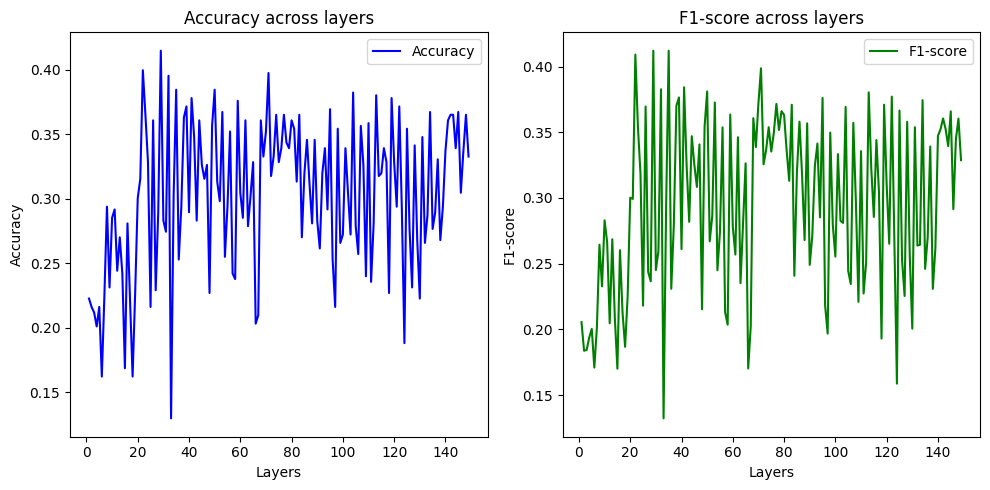

In [46]:
from tqdm.auto import tqdm
import gc

metrics_list = []

# Добавляем главный прогресс-бар
main_progress = tqdm(layers, desc="Processing layers", position=0, leave=True)

for layer in main_progress:
    main_progress.set_postfix_str(f"Current: {layer[:15]}...")  # Обрезаем длинные названия
    
    try:
        # 1. Получение активаций (сохраняем оригинальный вызов)
        train_acts, train_labels = get_activations_for_layer(
            acts_model, train_files, device, layer, train_labels)
        test_acts, test_labels = get_activations_for_layer(
            acts_model, test_files, device, layer, test_labels)

        # 2. Создание Dataset и DataLoader (как в оригинале)
        train_dataset = ActivationDataset(train_acts, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        test_dataset = ActivationDataset(test_acts, test_labels)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        # 3. Обучение модели (полностью сохраняем оригинальную логику)
        trained_model = train(
            train_loader, train_dataset.X.shape[-1], layer, device)
        
        # 4. Сохранение модели (как в оригинале)
        torch.save(trained_model.state_dict(), 
                  f"/kaggle/working/model_test.pth")
        
        # 5. Оценка модели
        metrics = evaluate(trained_model, test_loader, device)
        metrics_list.append((layer, metrics))
        print(layer, metrics)

        # 6. Очистка памяти (добавляем улучшения)
        del (train_acts, test_acts, train_dataset, test_dataset, 
             trained_model, train_loader, test_loader)
        gc.collect()
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"\nERROR in {layer}: {str(e)}")
        continue

# Финализируем сохранение (оригинальные вызовы)
save_metrics(metrics_list, '/kaggle/working/probing.txt')
plot_metrics(metrics_list, '/kaggle/working/probing.png')